# 3D Rock Property Modeling from Seismic + Well Logs Using Amazon SageMaker

---

---
## Contents
1. [Introduction](#Introduction)
2. [Setup](#Setup)
  1. [Fetching the dataset](#Fetching-the-dataset)
  2. [Data Ingestion](#Data-ingestion)
3. [Training the XGBoost model](#Training-the-XGBoost-model)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
  1. [Import model into hosting](#Import-model-into-hosting)
  2. [Create endpoint configuration](#Create-endpoint-configuration)
  3. [Create endpoint](#Create-endpoint)
5. [Validate the model for use](#Validate-the-model-for-use)

---
## Introduction

This notebook demonstrates the use of Amazon SageMaker’s implementation of the XGBoost algorithm to train and host a regression model for 3D modeling of rock properties by integrating seismic and well log data (in this case, density). This type of modeling is especially useful for when there is a limited number of wells are available which makes traditional seismic inversion very difficult. Geostatistics is also not an option for such cases because of the limited log info. In this example, data from only one well is used for modeling. Data from one well has been upscaled to seismic resolution, and is split into test, validation and training. Available seismic data for this example is a 2D section along with about 14 attributes extracted from it. This can be used for 3D data as well.  

#### Import libraries

In [ ]:
import sys
import segyio
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold , StratifiedKFold
#from classification_utilities import display_cm, display_adj_cm
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import preprocessing
from sklearn.model_selection import LeavePGroupsOut
from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.signal import medfilt
from xgboost.sklearn import  XGBClassifier 
from matplotlib import style
style.use('ggplot')
import pickle
import os
import boto3
import re
import sagemaker
from sagemaker import get_execution_role
seed = 7
np.random.seed(seed)

## Setup


This notebook was created and tested on an ml.m4.4xlarge notebook instance.

Let's start by specifying:
1. The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
1. The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [123]:
role = get_execution_role()
region = boto3.Session().region_name

bucket='petrophysics' # put your s3 bucket name here, and create s3 bucket
prefix = 'sagemaker/xgboost-byo-petrophysics-seismic-reg'
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)

CPU times: user 44 ms, sys: 8 ms, total: 52 ms
Wall time: 181 ms


### Define Seismic data ingestion methods

In [124]:
def segy_decomp(segy_file, plot_data = False, read_direc='xline', inp_res = np.float32):
    # segy_file: filename of the segy-cube to be imported
    # plot_data: boolean that determines if a random xline should be plotted to test the reading
    # read_direc: which way the SEGY-cube should be read; 'xline', or 'inline'
    # inp_res: input resolution, the formatting of the seismic cube (could be changed to 8-bit data)

    # Make an empty object to hold the output data
    print('Starting SEG-Y decompressor')
    output = segyio.spec()

    # open the segyfile and start decomposing it
    with segyio.open(segy_file, "r" ) as segyfile:
        # Memory map file for faster reading (especially if file is big...)
        segyfile.mmap()

        # Store some initial object attributes
        output.inl_start = segyfile.ilines[0]
        output.inl_end = segyfile.ilines[-1]
        output.inl_step = segyfile.ilines[1] - segyfile.ilines[0]

        output.xl_start = segyfile.xlines[0]
        output.xl_end = segyfile.xlines[-1]
        if output.xl_end==0:
            output.xl_step = 1
        else:   output.xl_step = segyfile.xlines[1] - segyfile.xlines[0]
                
        output.t_start = int(segyfile.samples[0])
        output.t_end = int(segyfile.samples[-1])
        output.t_step = int(segyfile.samples[1] - segyfile.samples[0])


        # Pre-allocate a numpy array that holds the SEGY-cube
        output.data = np.empty((segyfile.xline.len,segyfile.iline.len,\
                        (output.t_end - output.t_start)//output.t_step+1), dtype = np.float32)

        # Read the entire cube line by line in the desired direction
        if read_direc == 'inline':
            # Potentially time this to find the "fast" direction
            #start = time.time()
            for il_index in range(segyfile.xline.len):
                output.data[il_index,:,:] = segyfile.iline[segyfile.ilines[il_index]]
            #end = time.time()
            #print(end - start)

        elif read_direc == 'xline':
            # Potentially time this to find the "fast" direction
            #start = time.time()
            for xl_index in range(segyfile.iline.len):
                output.data[:,xl_index,:] = segyfile.xline[segyfile.xlines[xl_index]]
            #end = time.time()
            #print(end - start)

        elif read_direc == 'full':
            ## NOTE: 'full' for some reason invokes float32 data
            # Potentially time this to find the "fast" direction
            #start = time.time()
            output.data = segyio.tools.cube(segy_file)
            #end = time.time()
            #print(end - start)
        else:
            print('Define reading direction(read_direc) using either ''inline'', ''xline'', or ''full''')


        # If sepcified, plot a given x-line to test the read data
        if plot_data:
            # Take a given xline
            data = output.data[:,0,:]
            plt.imshow(data.T,interpolation="bilinear", cmap="jet")
            plt.colorbar()
#            plt.savefig(segy_file+'.tif')
            plt.show()


    # Return the output object
    print('Finished using the SEG-Y decompressor')
    return output


### Seismic Data ingestion

This is ======== DerI
Starting SEG-Y decompressor


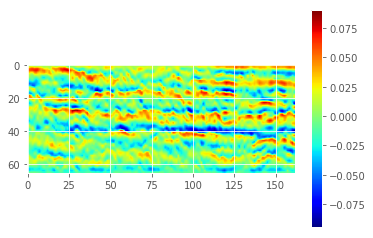

Finished using the SEG-Y decompressor
tmp.shape[0]*tmp.shape[1] (162, 66)
This is ======== 
Starting SEG-Y decompressor


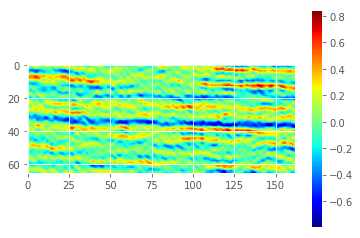

Finished using the SEG-Y decompressor
tmp.shape[0]*tmp.shape[1] (162, 66)
This is ======== fil
Starting SEG-Y decompressor


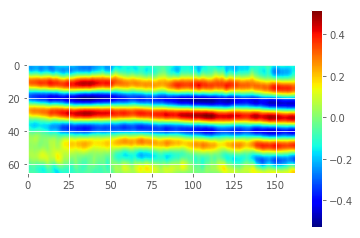

Finished using the SEG-Y decompressor
tmp.shape[0]*tmp.shape[1] (162, 66)
This is ======== In
Starting SEG-Y decompressor


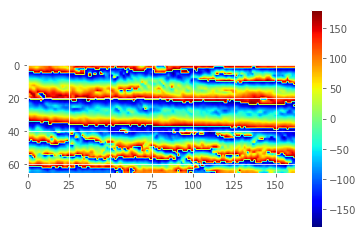

Finished using the SEG-Y decompressor
tmp.shape[0]*tmp.shape[1] (162, 66)
This is ======== SecDerI
Starting SEG-Y decompressor


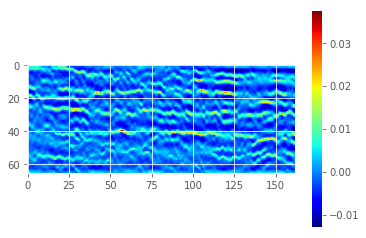

Finished using the SEG-Y decompressor
tmp.shape[0]*tmp.shape[1] (162, 66)
This is ======== In
Starting SEG-Y decompressor


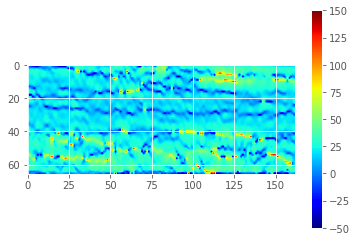

Finished using the SEG-Y decompressor
tmp.shape[0]*tmp.shape[1] (162, 66)
This is ======== 
Starting SEG-Y decompressor


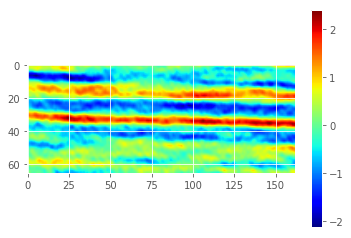

Finished using the SEG-Y decompressor
tmp.shape[0]*tmp.shape[1] (162, 66)
This is ======== CosIn
Starting SEG-Y decompressor


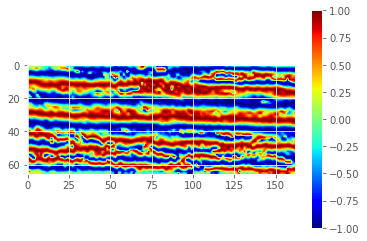

Finished using the SEG-Y decompressor
tmp.shape[0]*tmp.shape[1] (162, 66)
This is ======== 
Starting SEG-Y decompressor


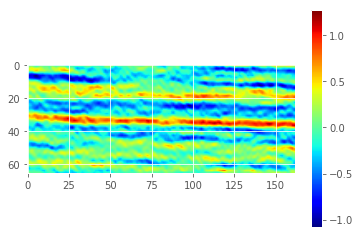

Finished using the SEG-Y decompressor
tmp.shape[0]*tmp.shape[1] (162, 66)
This is ======== AmpWei
Starting SEG-Y decompressor


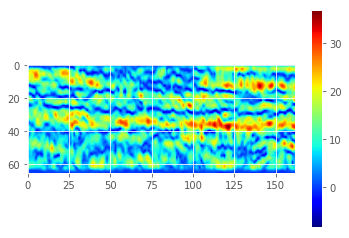

Finished using the SEG-Y decompressor
tmp.shape[0]*tmp.shape[1] (162, 66)
This is ======== fil
Starting SEG-Y decompressor


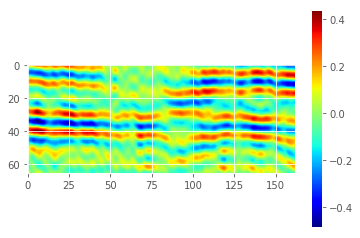

Finished using the SEG-Y decompressor
tmp.shape[0]*tmp.shape[1] (162, 66)
This is ======== S
Starting SEG-Y decompressor


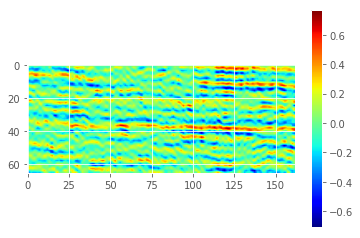

Finished using the SEG-Y decompressor
tmp.shape[0]*tmp.shape[1] (162, 66)
This is ======== A
Starting SEG-Y decompressor


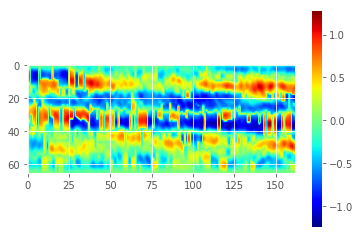

Finished using the SEG-Y decompressor
tmp.shape[0]*tmp.shape[1] (162, 66)


In [125]:
import glob
import scipy.io
import os
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
#mat = scipy.io.loadmat(r'E:\My files\Backup\Codes\China\2D attribute files\AppPol.mat')

segypath=r"segy_reg"
allFiles=glob.glob(segypath+'/*.segy')

file_names=os.listdir(segypath)
file_names = [s.split('/')[-1][0:-5] for s in allFiles]
#print(file_names)    
#stop
#i=0
samples, traces = 66,162
X=np.zeros((len(file_names),samples))

att=np.zeros((samples*traces,len(file_names)))
for fi in enumerate(allFiles):
    fn = file_names[fi[0]]
    fn=fn[:-5]
    print('This is ========',fn)
    tmp = segy_decomp(segy_file = fi[1],
                   plot_data = True,
                   read_direc = 'xline',
                   inp_res = np.float32 )
    tmp=tmp.data[:,0,:]
    print('tmp.shape[0]*tmp.shape[1]',tmp.shape)
    X[fi[0],:]=tmp[100,:]
    tmp=tmp.reshape(tmp.shape[0]*tmp.shape[1])
    att[:,fi[0]]=tmp
    
scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0)).fit(att)
att = scaler.transform(att)
X = scaler.transform(X.T)


In [126]:
print(att.shape)
print(file_names)
print(allFiles)
print(len(file_names))
print(len(allFiles))

All_Att_data = pd.DataFrame(att,columns = file_names)
Att_data = pd.DataFrame(X,columns = file_names)
display(All_Att_data.head())
display(Att_data.head())

All_Att_data.to_csv('All_Att_data.csv', index=False)
Att_data.to_csv('Att_data.csv', index=False)

(10692, 13)
['DerInsAmp', 'Der', 'filt1015', 'InsPhas', 'SecDerInsAmp', 'InsFreq', 'Integ', 'CosInsPhas', 'Quad', 'AmpWeigFreq', 'filt2025', 'SecDer', 'AppPol']
['segy_reg/DerInsAmp.segy', 'segy_reg/Der.segy', 'segy_reg/filt1015.segy', 'segy_reg/InsPhas.segy', 'segy_reg/SecDerInsAmp.segy', 'segy_reg/InsFreq.segy', 'segy_reg/Integ.segy', 'segy_reg/CosInsPhas.segy', 'segy_reg/Quad.segy', 'segy_reg/AmpWeigFreq.segy', 'segy_reg/filt2025.segy', 'segy_reg/SecDer.segy', 'segy_reg/AppPol.segy']
13
13


,DerInsAmp,Der,filt1015,InsPhas,SecDerInsAmp,InsFreq,Integ,CosInsPhas,Quad,AmpWeigFreq,filt2025,SecDer,AppPol
0,0.064511,0.654864,-0.492388,0.499312,0.799676,-1.008378,0.541060,0.058745,0.330998,-0.835955,1.104715,0.000000,0.179159
1,0.064511,0.654864,-0.584945,0.553518,0.799676,-2.235006,0.477217,-0.065034,-0.183744,-0.965143,0.879681,0.000000,0.191653
2,0.452765,0.535798,-0.613878,0.438484,0.799676,-1.446004,0.548598,0.195080,0.292931,-0.857752,0.349825,-0.134069,0.280642
3,1.486594,-0.595331,-0.565133,0.604569,1.847112,0.405576,0.442973,-0.180302,0.736427,0.128128,-0.319503,-1.273656,0.573323
4,1.404793,-1.250196,-0.434958,0.844935,0.037018,0.462290,-0.019326,-0.622075,0.679605,0.750175,-0.904840,-0.737379,0.849886


,DerInsAmp,Der,filt1015,InsPhas,SecDerInsAmp,InsFreq,Integ,CosInsPhas,Quad,AmpWeigFreq,filt2025,SecDer,AppPol
0,0.618954,0.000000,-0.405930,0.540113,-0.246928,-1.099105,0.866336,-0.034427,0.956611,-0.830269,-0.545002,0.000000e+00,-0.042995
1,0.618954,0.000000,-0.447114,0.693284,-0.246928,0.360274,0.382136,-0.368917,-0.089416,-0.398041,-0.366822,0.000000e+00,-0.164729
2,0.362147,0.520144,-0.468812,0.912934,-0.246928,0.146152,0.021814,-0.694699,-0.362173,-0.321423,-0.016430,5.856837e-01,-0.235864
3,0.043078,0.520144,-0.458931,-0.962204,-0.347947,-0.674980,-0.213747,-0.745652,-0.520686,-0.576862,0.424876,1.125236e-07,-0.244136
4,0.325047,0.086691,-0.405708,-0.832826,0.627231,-0.136658,-0.435941,-0.666662,-0.488347,-0.301193,0.825107,-4.880698e-01,-0.307962


### Following methods split the data into train/test/validation datasets and upload files to S3.

In [127]:
%%time

import io
import boto3
import random

def data_split(SEIS_FILE_DATA, WELL_DATA, FILE_TRAIN, FILE_VALIDATION, FILE_TEST, PERCENT_TRAIN, PERCENT_VALIDATION, PERCENT_TEST, TARGET_VAR):
    
    data = pd.read_csv(SEIS_FILE_DATA)
    well_data = pd.read_csv(WELL_DATA)    
    well_data = well_data[TARGET_VAR][:-3]
    
    
    n = data.shape[0]
    
    # Make the first column the target feature    
    cols = data.columns.tolist()
    data= pd.concat([well_data,data], axis=1)
        
    num_of_data = len(data)
    num_train = int((PERCENT_TRAIN/100.0)*n)
    num_valid = int((PERCENT_VALIDATION/100.0)*n)
    num_test = int((PERCENT_TEST/100.0)*n)
        
    # Shuffle the data
    data = data.sample(frac=1, replace=False)
    
    # Split data
    train_data = data.iloc[:num_train,:]
    test_data = data.iloc[(num_train+1):(num_train+1+num_test),:]
    valid_data = data.iloc[(num_train+1+num_test+1):n,:]
        
    # Save target column
    test_data.loc[:,TARGET_VAR].to_csv('labels_'+FILE_TEST, index=False, header=False)
    
    # Remove target colun from test set
    #test_data = test_data.drop([TARGET_VAR], axis=1)
    
    train_data.to_csv(FILE_TRAIN, index=False, header=False)
    valid_data.to_csv(FILE_VALIDATION, index=False, header=False)
    test_data.to_csv(FILE_TEST, index=False, header=False)
    
def write_to_s3(fobj, bucket, key):
    return boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(fobj)

def upload_to_s3(bucket, channel, filename):
    fobj=open(filename, 'rb')
    key = prefix+'/'+channel+'/'+filename
    url = 's3://{}/{}'.format(bucket, key)
    print('Writing to {}'.format(url))
    write_to_s3(fobj, bucket, key)     
    return(url)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 16.9 µs


### Well Log Data ingestion

When using the csv option, here is the critical piece of information about the data format:

> For CSV training, the algorithm assumes that the target variable is in the first column and that the CSV does not have a header record. For CSV inference, the algorithm assumes that CSV input does not have the label column.

[Source](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html)

In [128]:
display(wellA.head())

,den,sonic,gr
0,2.495152,85.764544,64.098011
1,2.497652,88.626222,69.026996
2,2.524589,100.930141,72.365433
3,2.522859,117.491444,75.283652
4,2.491270,144.238885,67.960419


### Split data

In [129]:
ALL_SEIS_FILE_DATA = 'All_Att_data.csv'
SEIS_FILE_DATA = 'Att_data.csv'
WELL_DATA = r'segy_reg/wellA.csv'
TARGET_VAR = 'den'
FILE_TRAIN = 'data_train.csv'
FILE_VALIDATION = 'data_validation.csv'
FILE_TEST = 'data_test.csv'
PERCENT_TRAIN = 70
PERCENT_VALIDATION = 15
PERCENT_TEST = 15

data_split(SEIS_FILE_DATA, WELL_DATA, FILE_TRAIN, FILE_VALIDATION, FILE_TEST, PERCENT_TRAIN, PERCENT_VALIDATION, PERCENT_TEST, TARGET_VAR)

### Upload the files to the S3 bucket

In [130]:
s3_train_loc = upload_to_s3(bucket = bucket, channel = 'train', filename = FILE_TRAIN)
s3_valid_loc = upload_to_s3(bucket = bucket, channel = 'validation', filename = FILE_VALIDATION)
s3_test_loc = upload_to_s3(bucket = bucket, channel = 'test', filename = FILE_TEST)

Writing to s3://petrophysics/sagemaker/xgboost-byo-petrophysics-seismic-reg/train/facies_train.csv
Writing to s3://petrophysics/sagemaker/xgboost-byo-petrophysics-seismic-reg/validation/facies_validation.csv
Writing to s3://petrophysics/sagemaker/xgboost-byo-petrophysics-seismic-reg/test/facies_test.csv


## Training the XGBoost model

After setting training parameters, we kick off training, and poll for status until training is completed, which in this example, takes between 5 and 6 minutes.

XGBoost hyperparameter [docs](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html).

In [131]:
# Instantiate the estimator
xgboost = sagemaker.estimator.Estimator('825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path='s3://{}/{}/output'.format(bucket, prefix),
                                       sagemaker_session=sagemaker.Session())

# Set the hyperparameters
xgboost.set_hyperparameters(max_depth=2,
                        n_estimators=100,
                        learning_rate=0.1,
                        min_child_weight=4,
                        objective='reg:linear',
                        num_round=100)

# Set the input data formatting and locatiopns
s3_input_train = sagemaker.s3_input(s3_data=s3_train_loc, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=s3_valid_loc, content_type='csv')

# Train the model
xgboost.fit({'train': s3_input_train, 'validation': s3_input_validation})

INFO:sagemaker:Creating training-job with name: xgboost-2018-03-18-16-31-40-858


..................................................................
Arguments: train
[2018-03-18:16:37:04:INFO] Running standalone xgboost training.
[2018-03-18:16:37:04:INFO] File size need to be processed in the node: 0.01mb. Available memory size in the node: 164.64mb
/opt/amazon/lib/python2.7/site-packages/sage_xgboost/train_helper.py:315: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(os.path.join(files_path, csv_file), sep=None, header=None)
[16:37:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[0]#011train-rmse:1.38536#011validation-rmse:1.38466
[1]#011train-rmse:0.978994#011validation-rmse:0.978415
[2]#011train-rmse:0.692104#011validation-rmse:0.691703
[16:37:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:3

===== Job Complete =====


In [133]:
xgboost_predictor = xgboost.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2018-03-18-16-39-53-110
INFO:sagemaker:Creating endpoint with name xgboost-2018-03-18-16-31-40-858


-----------------------------------------------------------------------------------!

## Validate the model for use
Finally, the customer can now validate the model for use. They can obtain the endpoint from the client library using the result from previous operations, and generate classifications from the trained model using that endpoint.


In [134]:
from sagemaker.predictor import csv_serializer

In [135]:
import numpy as np

def predict(data):
    rows=len(data)
    xgboost_predictor.content_type = 'text/csv'
    xgboost_predictor.serializer = csv_serializer
    xgboost_predictor.deserializer = None

    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgboost_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

test_data = pd.read_csv(FILE_TEST, header=None)
labels = test_data.iloc[:,0]
predictions = predict(test_data.as_matrix()[:, 1:]) # Note that we are not using the first column, which is the label

### 3D Prediction

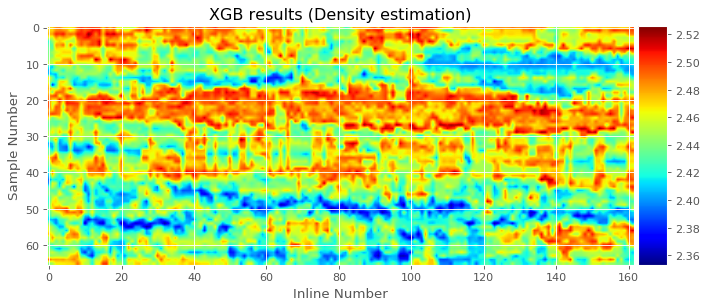

In [137]:
twoD = pd.read_csv('All_Att_data.csv', skiprows=0)
twoD=twoD.as_matrix()

twoDdata = predict(twoD)
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=(10,.8*10), dpi=80)
ax = plt.gca()
plt.title('XGB results (Density estimation)')
plt.ylabel('Sample Number')
plt.xlabel('Inline Number')
im = ax.imshow(twoDdata.reshape(traces,samples).T,interpolation="bilinear", cmap="jet")
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.savefig('xgb.tif')
plt.show()

### (Optional) Delete the Endpoint
If you're ready to be done with this notebook, make sure run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [11]:
print(xgboost_predictor.endpoint)

import sagemaker
sagemaker.Session().delete_endpoint(xgboost_predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: xgboost-2018-02-22-18-49-36-562


xgboost-2018-02-22-18-49-36-562
